In [1]:
import os
import sys
import json
import importlib
#import hashlib
#import itertools
#import warnings
import logging
import pandas as pd
#from metrics import get_metrics
#from sklearn import datasets as skl_datasets
#from scenarios import *
from plots import *
from experiments import ResultsEntry

PROJECT_ROOT = os.path.dirname(os.path.dirname(os.path.abspath('.')))
sys.path.append(PROJECT_ROOT)
#print(PROJECT_ROOT)
#from data_preprocessing.data_interface import get_data_sklearn, DataNotAvailable

import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
CONFIG_FILENAME = "example_loop_experiment_config.json"

In [3]:
with open(CONFIG_FILENAME, 'r') as f:
    config = json.loads(f.read())

datasets = config['datasets']
classifier_strings = config['classifiers']

classifiers = {}
for module_name, class_name in classifier_strings:
    module = importlib.import_module(module_name)
    class_ = getattr(module, class_name)
    classifiers[class_name] = class_

experiment_params = config['experiment_params']

results_filename = config['results_filename']

n_reps = config['n_reps']

mia_classifier_module, mia_classifier_name = config['mia_classifier']
module = importlib.import_module(mia_classifier_module)
mia_classifier = getattr(module, mia_classifier_name)

scenarios = config['scenarios']

In [4]:
results_df = pd.read_csv(results_filename)

In [10]:
results_df

,dataset,scenario,target_classifier,shadow_classifier_name,shadow_dataset,attack_classifier,repetition,full_id,model_data_param_id,param_id,...,max_depth,max_iter_predict,warm_start,solver,learning_rate,max_iter,n_neighbors,weights,probability,algorithm
0,mimic2-iaccd,WorstCase,RandomForestClassifier,NaN,NaN,RandomForestClassifier,0,e101b553cb58d2c8787b8c79f4b7f12d90d23df496cd06...,42898faa8f5781d9475a369de09df923fb3ac3a446968e...,c290c91cb238ae311deaef4efd43a26e5d8670f202850f...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mimic2-iaccd,Salem1,RandomForestClassifier,RandomForestClassifier,Same distribution,RandomForestClassifier,0,c87dcc59ee8ce75bae20e6c929968e16e907995fa4b58a...,42898faa8f5781d9475a369de09df923fb3ac3a446968e...,c290c91cb238ae311deaef4efd43a26e5d8670f202850f...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,mimic2-iaccd,Salem2,RandomForestClassifier,RandomForestClassifier,Breast cancer,RandomForestClassifier,0,b2e402142047cd1c95a8d86cf1f5b6d1db31ca085f2d9b...,42898faa8f5781d9475a369de09df923fb3ac3a446968e...,c290c91cb238ae311deaef4efd43a26e5d8670f202850f...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,mimic2-iaccd,WorstCase,RandomForestClassifier,NaN,NaN,RandomForestClassifier,0,e3066526e0a876c0030c51f773001adf81146938eca590...,0e30d7bc09dc139d956782c2082ced39a4d0558d6e9177...,7524bf76139cdf5d484323bf03e664121bedf1bdfb413f...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mimic2-iaccd,Salem1,RandomForestClassifier,RandomForestClassifier,Same distribution,RandomForestClassifier,0,de364566930a43f2eadbacf6d8b4658a16494781342c1e...,0e30d7bc09dc139d956782c2082ced39a4d0558d6e9177...,7524bf76139cdf5d484323bf03e664121bedf1bdfb413f...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,medical-mnist-ab-v-br-100,Salem1,AdaBoostClassifier,AdaBoostClassifier,Same distribution,RandomForestClassifier,4,3a8acc4d60df09c3433c80c3fc9cd73052b0dbfc1fad06...,1068f05df9c19fdfa5e558dada301e435d6b947c94ecff...,364ae7a59a41d1a1abe783fccffa1a758daccc058b9d6d...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMME
2696,medical-mnist-ab-v-br-100,Salem2,AdaBoostClassifier,AdaBoostClassifier,Breast cancer,RandomForestClassifier,4,a43b774f2dbda948955a35d3c7f9b0c534057ef995689d...,1068f05df9c19fdfa5e558dada301e435d6b947c94ecff...,364ae7a59a41d1a1abe783fccffa1a758daccc058b9d6d...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMME
2697,medical-mnist-ab-v-br-100,WorstCase,AdaBoostClassifier,NaN,NaN,RandomForestClassifier,4,0fad4c0f8ad3139b61c64cea9451cb7b1d187fd119f7bc...,0f1f54b176b26def0a32a2fe513e2de4f3f65f5ca9cc1e...,690a37a5d9732ebf685adc698801ddf5894a46f2ef9e0e...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMME.R
2698,medical-mnist-ab-v-br-100,Salem1,AdaBoostClassifier,AdaBoostClassifier,Same distribution,RandomForestClassifier,4,b0f061587105ebaf9511f66b11031a25807e2a57a73ab3...,0f1f54b176b26def0a32a2fe513e2de4f3f65f5ca9cc1e...,690a37a5d9732ebf685adc698801ddf5894a46f2ef9e0e...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMME.R


In [5]:
results_df.columns

Index(['dataset', 'scenario', 'target_classifier', 'shadow_classifier_name',
       'shadow_dataset', 'attack_classifier', 'repetition', 'full_id',
       'model_data_param_id', 'param_id', 'bootstrap', 'min_samples_split',
       'target_TPR', 'target_FPR', 'target_FAR', 'target_TNR', 'target_PPV',
       'target_NPV', 'target_FNR', 'target_ACC', 'target_Advantage',
       'target_AUC', 'mia_TPR', 'mia_FPR', 'mia_FAR', 'mia_TNR', 'mia_PPV',
       'mia_NPV', 'mia_FNR', 'mia_ACC', 'mia_Advantage', 'mia_AUC',
       'shadow_TPR', 'shadow_FPR', 'shadow_FAR', 'shadow_TNR', 'shadow_PPV',
       'shadow_NPV', 'shadow_FNR', 'shadow_ACC', 'shadow_Advantage',
       'shadow_AUC', 'max_depth', 'max_iter_predict', 'warm_start', 'solver',
       'learning_rate', 'max_iter', 'n_neighbors', 'weights', 'probability',
       'algorithm'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

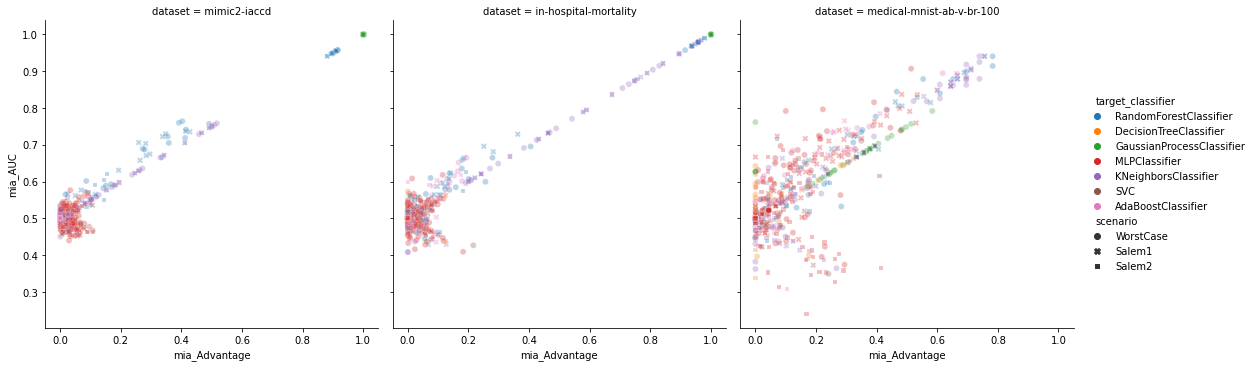

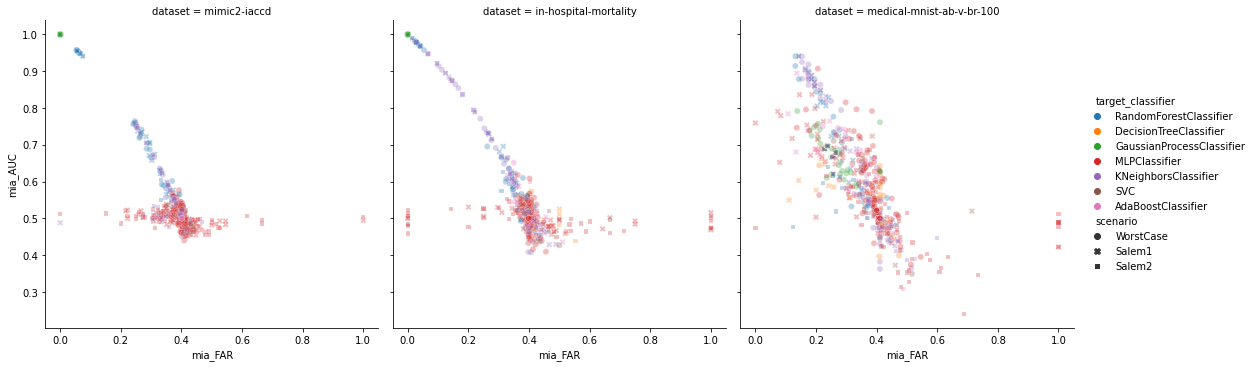

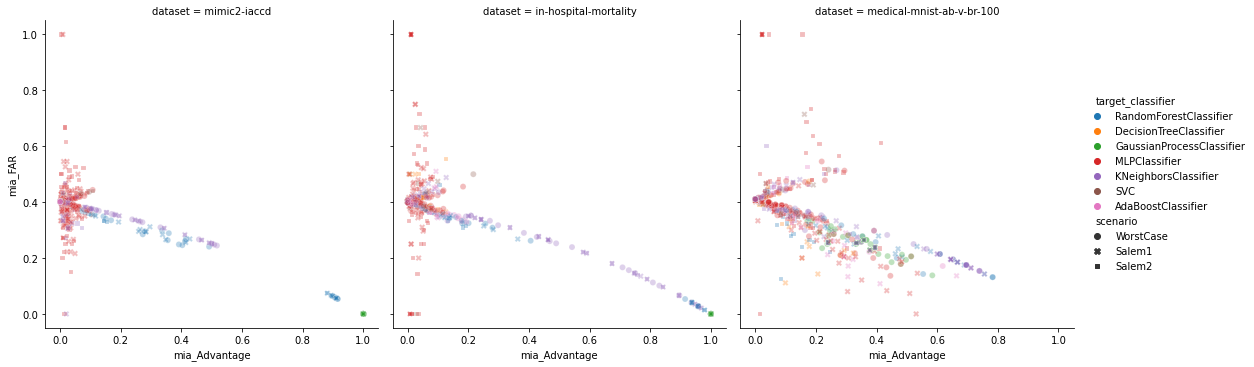

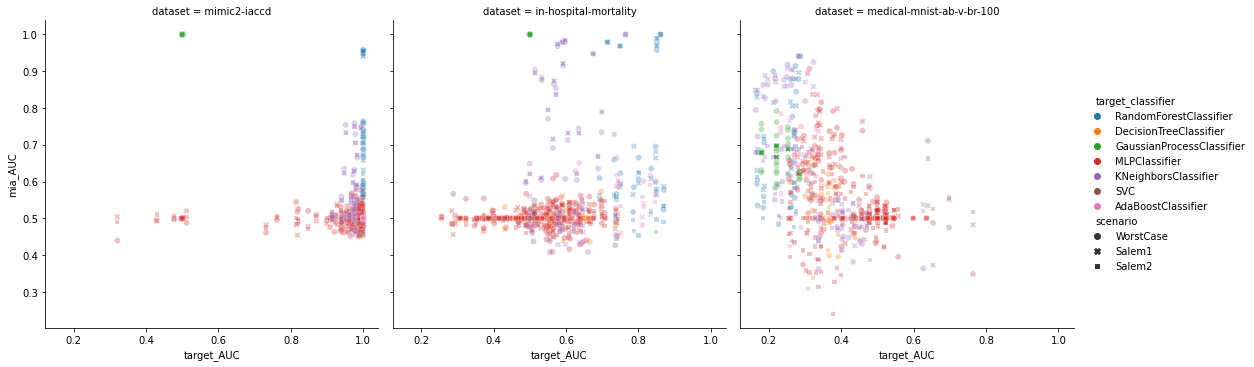

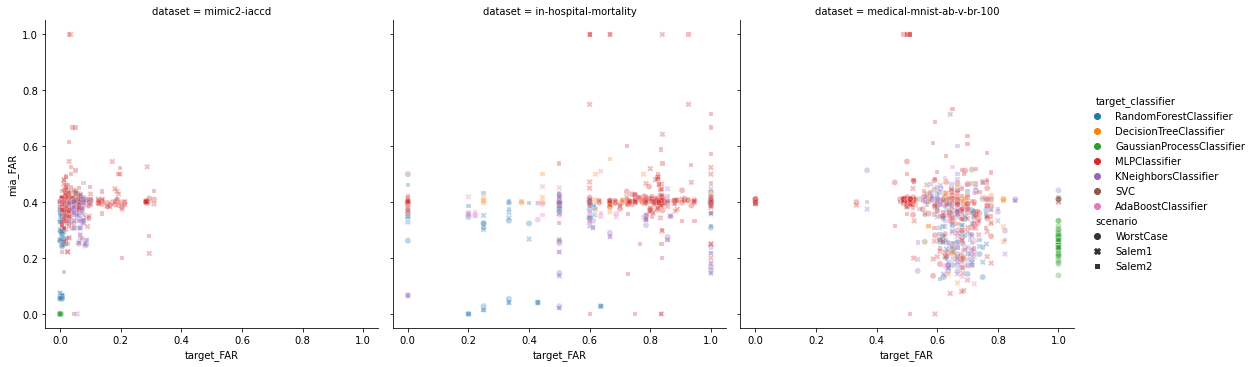

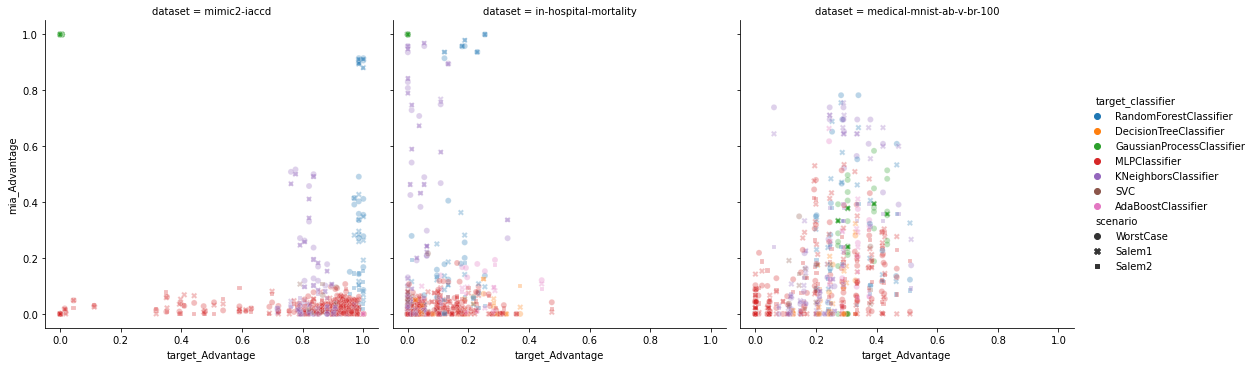

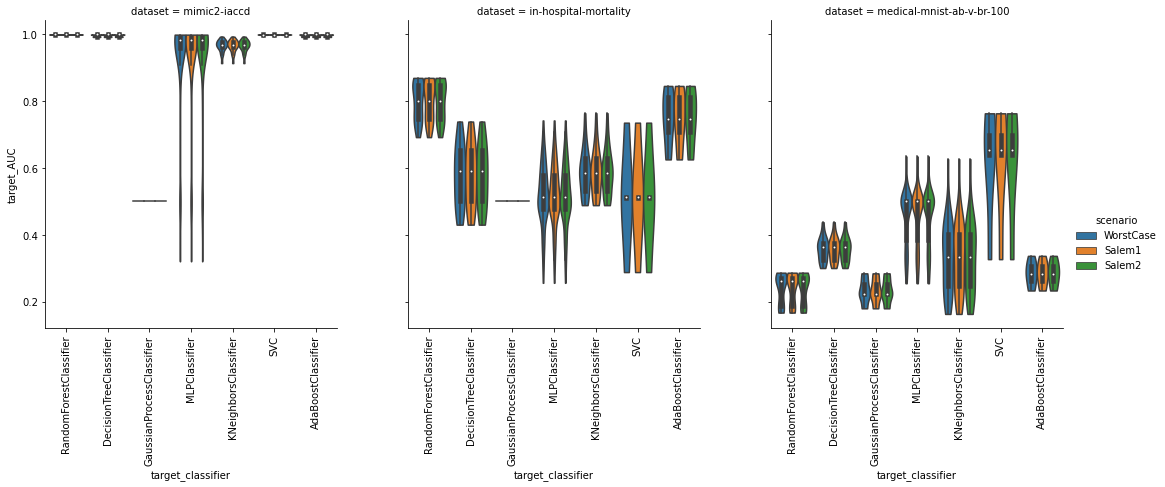

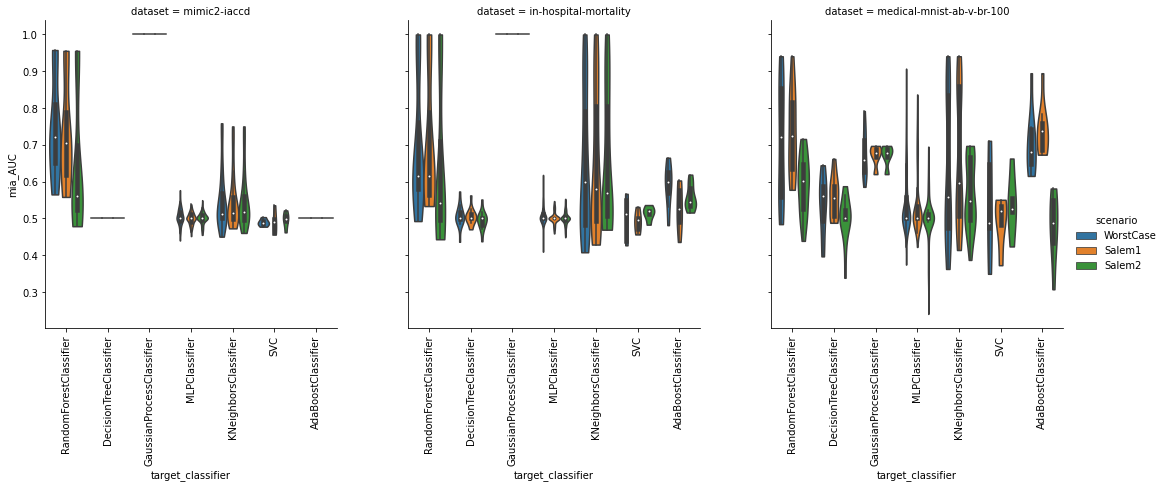

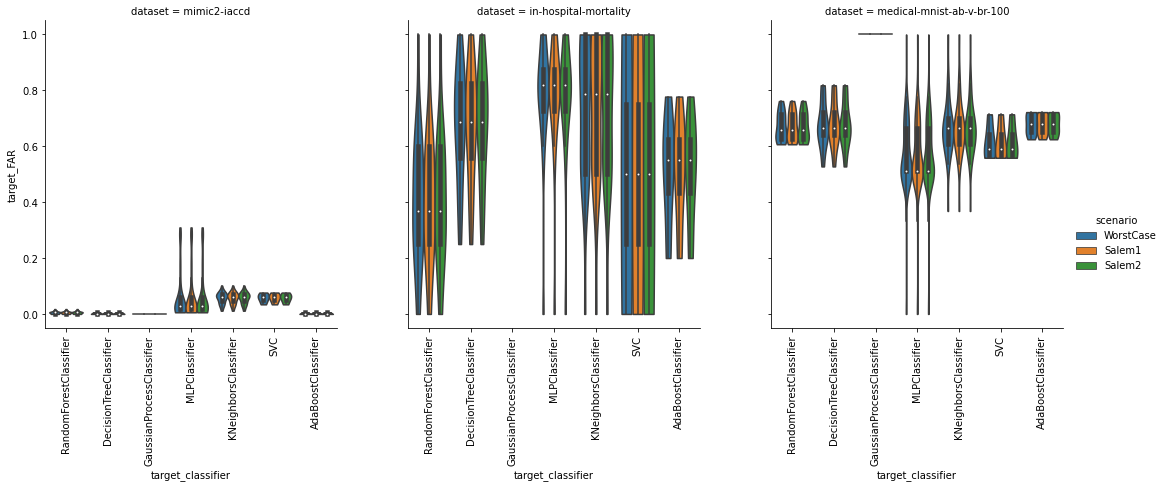

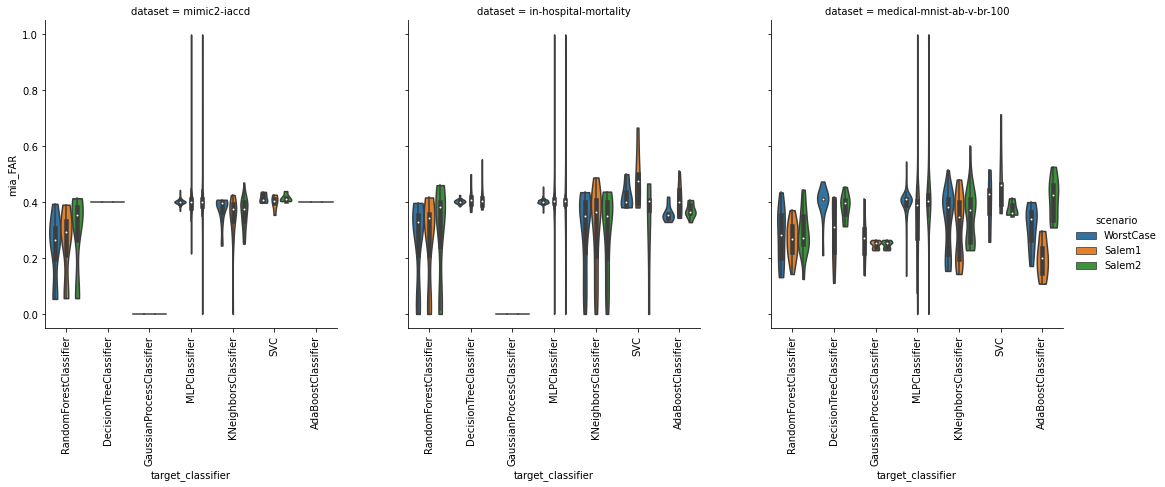

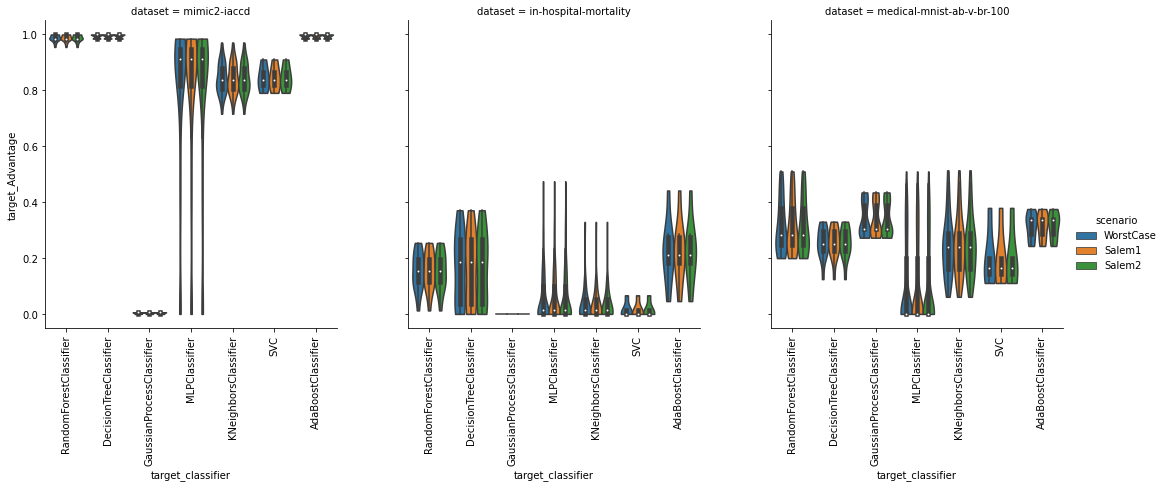

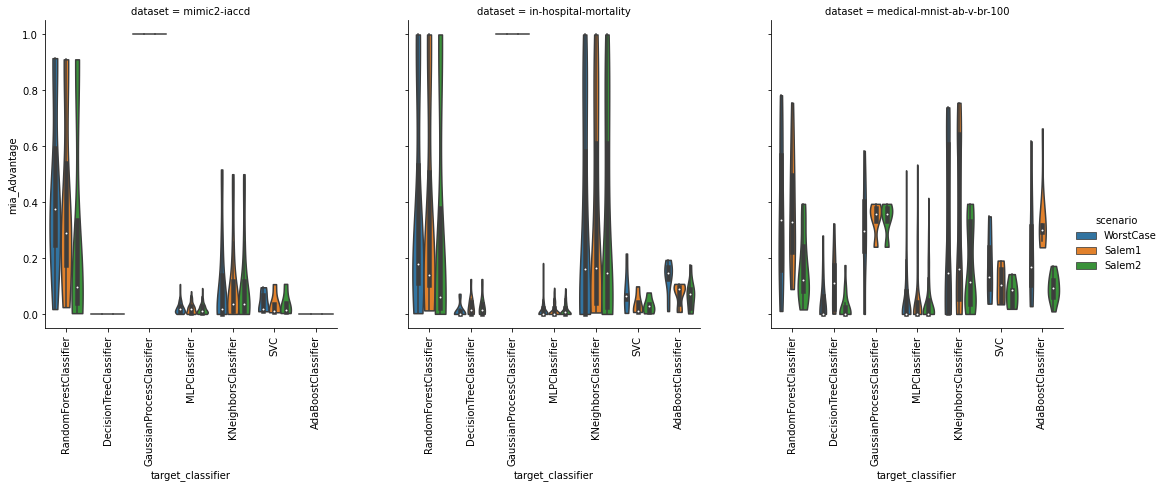

In [9]:
logging.getLogger('matplotlib').setLevel(logging.WARNING)

with PdfPages('explore_results_tmp.pdf') as pdf_pages:
    #df1 = dftest.select_dtypes([np.int, np.float, np.object])
    i = 0
    figu = plt.figure(i)
        #countplot = sns.countplot(x=col, data=df1)
        
    sns.relplot(
        data=results_df, x="mia_Advantage", y="mia_AUC",
        hue="target_classifier", style="scenario", col="dataset",
        kind="scatter", alpha=0.3
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.relplot(
        data=results_df, x="mia_FAR", y="mia_AUC",
        hue="target_classifier", style="scenario", col="dataset",
        kind="scatter", alpha=0.3
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.relplot(
        data=results_df, x="mia_Advantage", y="mia_FAR",
        hue="target_classifier", style="scenario", col="dataset",
        kind="scatter", alpha=0.3
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)    
    sns.relplot(
        data=results_df, x="target_AUC", y="mia_AUC",
        hue="target_classifier", style="scenario", col="dataset",
        kind="scatter", alpha=0.3
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.relplot(
        data=results_df, x="target_FAR", y="mia_FAR",
        hue="target_classifier", style="scenario", col="dataset",
        kind="scatter", alpha=0.3
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.relplot(
        data=results_df, x="target_Advantage", y="mia_Advantage",
        hue="target_classifier", style="scenario", col="dataset",
        kind="scatter", alpha=0.3
    )

    var = ['target_AUC', 'mia_AUC',
           'target_FAR', 'mia_FAR',
           'target_Advantage', 'mia_Advantage',
          ]
    for v in var:
    
        i+=1
        figu = plt.figure(i)
        sns.catplot(data=results_df, x="target_classifier", y=v,
                hue="scenario", col="dataset", #row="target_classifier",
                cut=0,
               kind='violin').set_xticklabels(rotation=90)
        pdf_pages.savefig(figu)

In [ ]:
sns.relplot(
    data=results_df, x="target_AUC", y="mia_AUC",
    hue="target_classifier", style="scenario", col="dataset",
    kind="scatter", alpha=0.3
)
sns.relplot(
    data=results_df, x="target_FAR", y="mia_FAR",
    hue="target_classifier", style="scenario", col="dataset",
    kind="scatter", alpha=0.3
)
sns.relplot(
    data=results_df, x="target_Advantage", y="mia_Advantage",
    hue="target_classifier", style="scenario", col="dataset",
    kind="scatter", alpha=0.3
)

In [ ]:
var = ['target_AUC', 'mia_AUC',
       'target_FAR', 'mia_FAR',
       'target_Advantage', 'mia_Advantage',
      ]
for v in var:
    sns.catplot(data=results_df, x="target_classifier", y=v,
            hue="scenario", col="dataset", #row="target_classifier",
            cut=0,
           kind='violin').set_xticklabels(rotation=90)